In [1]:
import torch
from algo_reasoning.src.sampler import CLRSDataset
from pathlib import Path

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/ronaldalbert/Documents/env/algo_reasoning/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from algo_reasoning.src.models.network import EncodeProcessDecode
from algo_reasoning.src.lightning.AlgorithmicReasoningTask import AlgorithmicReasoningTask 
from algo_reasoning.src.specs import CLRS_30_ALGS
from algo_reasoning.src.losses.AlgorithmicReasoningLoss import AlgorithmicReasoningLoss

# Define function for loading models

In [3]:
def load_models(algorithms):
    mpnn_ckpt_path = str(next(Path(f"../checkpoints/{algorithms[0]}/").glob(f"{algorithms[0]}-mpnn0*")))
    spectral_ckpt_path = str(next(Path(f"../checkpoints/{algorithms[0]}/").glob(f"{algorithms[0]}-spectralmpnn0*")))

    model_mpnn = EncodeProcessDecode(algorithms, processor='mpnn')
    model_spectral = EncodeProcessDecode(algorithms, processor='spectralmpnn2')

    loss_fn = AlgorithmicReasoningLoss()
    
    mpnn = AlgorithmicReasoningTask.load_from_checkpoint(mpnn_ckpt_path, model=model_mpnn, loss_fn=loss_fn, strict=False).model.to(device)
    spectral = model = AlgorithmicReasoningTask.load_from_checkpoint(spectral_ckpt_path, model=model_spectral, loss_fn=loss_fn, strict=False).model.to(device)

    mpnn.eval()
    spectral.eval()
    return mpnn, spectral

# Compute Fourier Features

In [4]:
def fourier_transform(embeddings, adj_matrix=None):
    """
    Compute the Fourier Transform of the embeddings.

    Args:
        embeddings: a tensor of shape (batch_size, sequence_length, embedding_dim)

    Returns:
        a tensor of shape (batch_size, sequence_length, embedding_dim)
    """
    if adj_matrix is None:
        adj_matrix = torch.ones((embeddings.size(0), embeddings.size(-2),embeddings.size(-2)), device=device)
    degrees = torch.sum(adj_matrix, dim=1)
    degree_matrix = torch.stack([torch.diag(degrees[d]) for d in range(degrees.size(0))], dim=0)
    laplacian = degree_matrix - adj_matrix
    
    result = torch.linalg.eigh(laplacian)
    eigenvalues = result.eigenvalues
    eigenvectors = result.eigenvectors
    
    eigenvalues[torch.isclose(eigenvalues, torch.tensor(0.))] = 0.

    return eigenvectors.transpose(-2, -1)@embeddings, eigenvectors, eigenvalues

# Load Default Algorithm Args

In [5]:
def load_algorithm_args(args_file):
    with open(args_file, 'r') as f:
        args = yaml.safe_load(f)

    return args

algorithm_args = "algorithm_args/default.yaml"

In [6]:
algorithms = ["articulation_points"]

nb_nodes = 16
ds = CLRSDataset(algorithms, nb_nodes, 8, 1000, seed=7, algorithms_args=algorithm_args)

In [7]:
mpnn_model, spectral_model = load_models(algorithms)

obj = next(iter(ds)).to(device=device)

output_mpnn, output_spectral  = mpnn_model(obj), spectral_model(obj)
adj_matrix = obj.inputs.A
embeddings_mpnn, embeddings_spectral = output_mpnn.hidden_embeddings, output_spectral.hidden_embeddings

In [8]:
fourier_embeddings_mpnn, eigenvectors_mpnn, eigenvalues_mpnn = fourier_transform(embeddings_mpnn[:, 0], adj_matrix)
fourier_embeddings_spectral, eigenvectors_spectral, eigenvalues_spectral = fourier_transform(embeddings_spectral[:, 0], adj_matrix)

<BarContainer object of 16 artists>

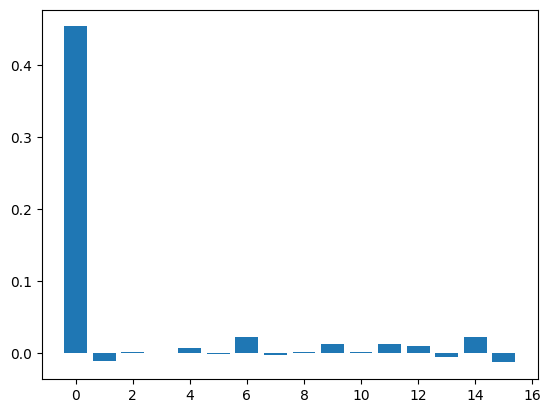

In [10]:
import matplotlib.pyplot as plt

plot_data = torch.mean(fourier_embeddings_mpnn, dim=-1)

plt.bar(x=[i for i in range(nb_nodes)], height=plot_data[0].detach().cpu().numpy())


<BarContainer object of 16 artists>

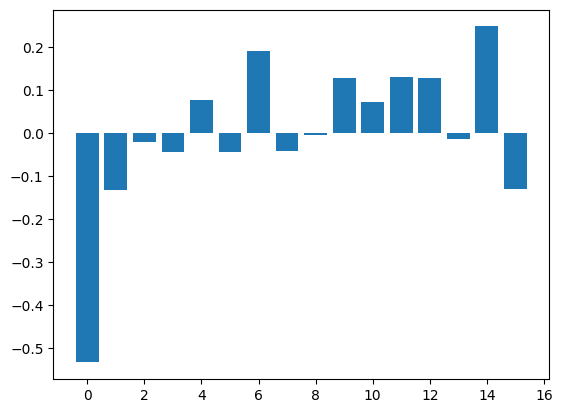

In [11]:
import matplotlib.pyplot as plt

plot_data = torch.mean(fourier_embeddings_spectral, dim=-1)

plt.bar(x=[i for i in range(nb_nodes)], height=plot_data[0].detach().cpu().numpy())


In [ ]:
#ckpt_path = str(next(Path(f"../checkpoints/{algorithms[0]}/").glob(f"{algorithms[0]}-mpnn*")))

loss_fn = AlgorithmicReasoningLoss()

model = AlgorithmicReasoningTask.load_from_checkpoint(ckpt_path, model=model, loss_fn=loss_fn, strict=False).model.to(device)